# ※ naver Open Api를 활용하여 네이버 지식인 "전주 여행"과 "경주 여행"을 검색 -> 명사만 추출(re) -> 빈도분석(DataFrame), 시각화(워드클라우드)

# 1. 네이버 api를 활용하여 두 검색어 추출

In [1]:
import os
import sys
import urllib.request
client_id = "2zOOToU7fufmVxfwEi8R"
client_secret = "j2bpvsf0qK"
encText = urllib.parse.quote("경주 여행")
url = "https://openapi.naver.com/v1/search/blog?query=" + encText # JSON 결과
# url = "https://openapi.naver.com/v1/search/blog.xml?query=" + encText # XML 결과
request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
response = urllib.request.urlopen(request)
rescode = response.getcode()
if(rescode==200):
    response_body = response.read()
    print(response_body.decode('utf-8'))
else:
    print("Error Code:" + rescode)

{
	"lastBuildDate":"Tue, 31 Dec 2024 13:04:04 +0900",
	"total":876745,
	"start":1,
	"display":10,
	"items":[
		{
			"title":"<b>경주여행<\/b> 대릉원 드론촬영하기! (경주시청허가必)",
			"link":"https:\/\/blog.naver.com\/cooooooook\/223658719098",
			"description":"사진 ⓒ쿠우욱 안녕하세요 여행블로거 쿠우욱입니다 지난 <b>경주여행<\/b>을 떠나기전 경주 유적지들의 드론촬영을 해보고 싶어서 미리 경주시 문화유산과에 촬영 허가를 받고 방문하였습니다 :D 경주대릉원  위치... ",
			"bloggername":"태리네 가족은 여행중",
			"bloggerlink":"blog.naver.com\/cooooooook",
			"postdate":"20241113"
		},
		{
			"title":"<b>경주여행<\/b> 경주힐튼 조식 포함 숙박후기 실내수영장",
			"link":"https:\/\/blog.naver.com\/kkuik20\/223702301723",
			"description":"<b>경주여행<\/b> 경주힐튼 조식 포함 숙박후기 실내수영장 연말 <b>경주 여행<\/b> 오랜만에 와이프와 함께 <b>경주 여행<\/b>을 하게 되었다. 사실 경주 자체가 목적이었다기보다는 와이프 출장건과 더불어 여행과 주변 지역에... ",
			"bloggername":"꾸익의 일상",
			"bloggerlink":"blog.naver.com\/kkuik20",
			"postdate":"20241222"
		},
		{
			"title":"<b>경주 여행<\/b>코스 루지월드에서 만난 보물",
			"link":"https:\/\/blog.naver.com\/dcndb\/223661667998",
			"description":"이번에 처음 간 루지월드지만 나중에 <b>경주여행<\

In [2]:
from requests import get
import time
import os
import json
from html import unescape # &lt; -> <, &gt;-> >
import pandas as pd

In [3]:
# 네이버 API 계정 정보
client_id = 'PEdh_oUh_6HvzCnKIEa7'
client_secret = 'FPyGzkvQLD'
queries = ['전주 여행', '경주 여행']
max_start = 5

In [4]:
query = "전주 여행"
start = 0
headers = {'X-Naver-Client-Id':client_id,
           'X-Naver-Client-Secret':client_secret}
url = f'https://openapi.naver.com/v1/search/kin.json?query={query}&display=100&start={start+1}'
response = get(url, headers=headers)
print(response.text[:500])

{
	"lastBuildDate":"Tue, 31 Dec 2024 13:04:05 +0900",
	"total":47111,
	"start":1,
	"display":100,
	"items":[
		{
			"title":"<b>전주여행<\/b> 대중교통이랑 렌트카중 어떤게 좋을까요?",
			"link":"https:\/\/kin.naver.com\/qna\/detail.naver?d1id=9&dirId=90110&docId=477694429&qb=7KCE7KO8IOyXrO2WiQ==&enc=utf8&section=kin.qna&rank=1&search_sort=0&spq=0",
			"description":"... <b>전주여행<\/b>때 움직이기 차가 편할지 대중교통이 편할지 알려주세요. 교통 상황이 어떤지 궁금합니다. <b>전주여행<\/b> 전주맛집 국내여행 전주달봉이 달봉티비 <b>전주여행<\/b>코스 전주가볼만한곳 여수여행 여수가볼만한곳 제주도여행... "
		},
		


In [5]:
# 데이터를 저장할 파일 생성 (naver_kin.txt)하고 title 저장
file_name = 'data/naver_kin.txt'
with open(file_name, 'w', encoding='utf-8') as file:
    file.write('{}\t{}\t{}\t{}\t{}\t{}\n'.format('query', 
                            'no','title','link', 'description', 'total_text'))

In [6]:
elements = json.loads(response.text)['items']
elements[0]

{'title': '<b>전주여행</b> 대중교통이랑 렌트카중 어떤게 좋을까요?',
 'link': 'https://kin.naver.com/qna/detail.naver?d1id=9&dirId=90110&docId=477694429&qb=7KCE7KO8IOyXrO2WiQ==&enc=utf8&section=kin.qna&rank=1&search_sort=0&spq=0',
 'description': '... <b>전주여행</b>때 움직이기 차가 편할지 대중교통이 편할지 알려주세요. 교통 상황이 어떤지 궁금합니다. <b>전주여행</b> 전주맛집 국내여행 전주달봉이 달봉티비 <b>전주여행</b>코스 전주가볼만한곳 여수여행 여수가볼만한곳 제주도여행... '}

In [7]:
for i, element in enumerate(elements):
    title = element['title'].replace('<b>', ' ').replace('</b>', ' ')
    link = element['link']
    description = element['description'].replace('<b>', ' ').replace('</b>', ' ')
    description = unescape(description) # html 특수문자 처리(&lt; -> <로 대체)
    # print(query, (start*100+i+1), title, link, description, title+' ' +description)
    with open(file_name, 'a', encoding='utf-8') as file:
        file.write('{}\t{}\t{}\t{}\t{}\t{}\n'.format(query, 
                                                     start*100+i+1,
                                                     title,
                                                     link,
                                                     description, 
                                                     title + ' ' +description))

In [8]:
df = pd.read_csv('data/naver_kin.txt', sep='\t')
df.head(2)

,query,no,title,link,description,total_text
0,전주 여행,1,전주여행 대중교통이랑 렌트카중 어떤게 좋을까요?,https://kin.naver.com/qna/detail.naver?d1id=9&...,... 전주여행 때 움직이기 차가 편할지 대중교통이 편할지 알려주세요. 교통 상황...,전주여행 대중교통이랑 렌트카중 어떤게 좋을까요? ... 전주여행 때 움직이기 ...
1,전주 여행,2,전주여행 갈려고하는데요!,https://kin.naver.com/qna/detail.naver?d1id=9&...,전주여행 을 갈려고하는데요!아는사람과 갈려고하는데 호텔은 좋은가격에 정했고~ 음....,전주여행 갈려고하는데요! 전주여행 을 갈려고하는데요!아는사람과 갈려고하는데 호텔...


# 내일(12.31)

In [9]:
from requests import get
import time
import os
import json
from html import unescape # &lt; -> <, &gt;-> >
import pandas as pd

In [10]:
# 네이버 API 계정 정보
client_id = 'PEdh_oUh_6HvzCnKIEa7'
client_secret = 'FPyGzkvQLD'
queries = ['전주 여행', '경주 여행']
max_start = 5

In [11]:
def get_search_element_save(query, start):
    headers = {'X-Naver-Client-Id':client_id,
           'X-Naver-Client-Secret':client_secret}
    url = f'https://openapi.naver.com/v1/search/kin.json?query={query}&display=100&start={start+1}'
    response = get(url, headers=headers)
    elements = json.loads(response.text)['items']
    for i, element in enumerate(elements):
        title = element['title'].replace('<b>', ' ').replace('</b>', ' ')
        link = element['link']
        description = element['description'].replace('<b>', ' ').replace('</b>', ' ')
        description = unescape(description) # html 특수문자 처리(&lt; -> <로 대체)
        # print(query, (start*100+i+1), title, link, description, title+' ' +description)
        with open(file_name, 'a', encoding='utf-8') as file:
            file.write('{}\t{}\t{}\t{}\t{}\t{}\n'.format(query, 
                                                         start*100+i+1,
                                                         title,
                                                         link,
                                                         description, 
                                                         title + ' ' +description))

In [12]:
# 데이터를 저장할 파일 생성 (naver_kin.txt)하고 title 저장
file_name = 'data/naver_kin.txt'
with open(file_name, 'w', encoding='utf-8') as file:
    file.write('{}\t{}\t{}\t{}\t{}\t{}\n'.format('query', 
                            'no','title','link', 'description', 'total_text'))

In [13]:
for query in queries:
    for start in range(max_start):
        print(start, query, '읽고 파일 쓰기 중')
        get_search_element_save(query, start)
        time.sleep(0.3)

0 전주 여행 읽고 파일 쓰기 중
1 전주 여행 읽고 파일 쓰기 중
2 전주 여행 읽고 파일 쓰기 중
3 전주 여행 읽고 파일 쓰기 중
4 전주 여행 읽고 파일 쓰기 중
0 경주 여행 읽고 파일 쓰기 중
1 경주 여행 읽고 파일 쓰기 중
2 경주 여행 읽고 파일 쓰기 중
3 경주 여행 읽고 파일 쓰기 중
4 경주 여행 읽고 파일 쓰기 중


# 2. 품사 태깅 저장

In [14]:
df = pd.read_csv('data/naver_kin.txt', sep='\t')
df.sample()

,query,no,title,link,description,total_text
581,경주 여행,82,경주 여행 감성 독채 자쿠지 숙소 추천 부탁드립니다.,https://kin.naver.com/qna/detail.naver?d1id=9&...,"3월 마지막 주에 경주 여행 을 계획하고 있습니다. 어른5명, 4세 아이 가능한 ...",경주 여행 감성 독채 자쿠지 숙소 추천 부탁드립니다. 3월 마지막 주에 경주 ...


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   query        1000 non-null   object
 1   no           1000 non-null   int64 
 2   title        1000 non-null   object
 3   link         1000 non-null   object
 4   description  1000 non-null   object
 5   total_text   1000 non-null   object
dtypes: int64(1), object(5)
memory usage: 47.0+ KB


In [16]:
# 데이터 프레임은 for문을 돌릴 경우 컬럼명만 적용
for row in df:
    print(row)

query
no
title
link
description
total_text


In [17]:
# 데이터 프레임을 for문 적용을 위해 list로 형변환
df_list = df[['query','no','total_text']].values.tolist()
print(type(df_list))
print(df_list[::250])

<class 'list'>
[['전주 여행', 1, ' 전주여행  대중교통이랑 렌트카중 어떤게 좋을까요? ...  전주여행 때 움직이기 차가 편할지 대중교통이 편할지 알려주세요. 교통 상황이 어떤지 궁금합니다.  전주여행  전주맛집 국내여행 전주달봉이 달봉티비  전주여행 코스 전주가볼만한곳 여수여행 여수가볼만한곳 제주도여행... '], ['전주 여행', 251, '내일  전주  당일치기 부모님과  여행 을 ...  전주여행  전주맛집 국내여행 전주달봉이 달봉티비  전주여행 코스 전주가볼만한곳 여수여행 여수가볼만한곳 제주도여행 제주도가볼만한곳 여행 전문 인플루언서 전주달봉이입니다. 바다는 군산 새만금 돌아보시면... '], ['경주 여행', 1, '추석에  경주 여행  추석에  경주 여행  가는거 어떻게 생각하시나요? 서울에서 버스를 타고 갈 경우, 버스가 버스전용 차선에서 운행하나요?... 질문하신 [추석  경주여행 ] 관련 답변 드리도록 하겠습니다. 첨성대, 석굴암, 불국사 등 유적지는 연중무휴로... '], ['경주 여행', 251, '[추천해주세요]  경주여행  [추천해주세요]  경주여행  안녕하세요~~ 무계획 이 루트로 이용시 실패없는  경주여행  소개해드릴까 합니다 ㅎㅎ 한번 보시고 마음에 드신다면 채택 부탁드립니다~~']]


In [18]:
file_name = 'data/naver_kin_pos.csv'
with open(file_name, 'w', encoding='cp949') as file:
    file.write('{},{},{},{}\n'.format('query','no','token', 'pos'))

In [19]:
from konlpy.tag import Hannanum, Kkma, Komoran, Okt
from mecab import MeCab
stopwords = ['여행','전주','경주']
# 원하는 품사 : 일반명사, 고유명사
select_pos = ['N'] # Hannanum(ntags=9)
# select_pos = ['NC','NQ'] # Hannanum(ntags=22)
# select_pos = ['NNG', 'NNP'] # Kkma, Komoran, MeCab
# select_pos = ['Noun'] # Okt

In [20]:
# ㅠ, 음, ㅋㅋ, ㅎㅎ
import re
text = '음. 경주ㅎㅎ좋아요 ㅎㅎ 진짜 일까? ㅠㅠ'
re.sub('[^가-힣\s]', ' ', text) # ^ : 반대

'음  경주  좋아요    진짜 일까    '

In [21]:
# pos_tagger = Hannanum()
pos_tagger = Komoran() # 띄어쓰기를 안해도 최선을 다해 형태소분석
for i, row in enumerate(df_list):
    query = row[0]
    no = row[1]
    text = row[2]
#     print('수정전 :', text)
    text = re.sub('[^가-힣\s]', ' ', text)
    text = re.sub('[\s+]', ' ', text)
#     print('수정후 :', text, end='\n\n')
    text_pos = pos_tagger.pos(text)
    if i%250 == 0:
        print(query, no, len(text), text, end='\n\n')
    for token, pos in text_pos:
#         if token not in stopwords and pos in select_pos and len(token) > 1 :
        if token not in stopwords and len(token) > 1 :
            with open(file_name, 'a', encoding='cp949') as file:
                file.write('{},{},{},{}\n'.format(query, no, token, pos))

전주 여행 1 155  전주여행  대중교통이랑 렌트카중 어떤게 좋을까요       전주여행 때 움직이기 차가 편할지 대중교통이 편할지 알려주세요  교통 상황이 어떤지 궁금합니다   전주여행  전주맛집 국내여행 전주달봉이 달봉티비  전주여행 코스 전주가볼만한곳 여수여행 여수가볼만한곳 제주도여행    

전주 여행 251 143 내일  전주  당일치기 부모님과  여행 을      전주여행  전주맛집 국내여행 전주달봉이 달봉티비  전주여행 코스 전주가볼만한곳 여수여행 여수가볼만한곳 제주도여행 제주도가볼만한곳 여행 전문 인플루언서 전주달봉이입니다  바다는 군산 새만금 돌아보시면    

경주 여행 1 147 추석에  경주 여행  추석에  경주 여행  가는거 어떻게 생각하시나요  서울에서 버스를 타고 갈 경우  버스가 버스전용 차선에서 운행하나요     질문하신  추석  경주여행   관련 답변 드리도록 하겠습니다  첨성대  석굴암  불국사 등 유적지는 연중무휴로    

경주 여행 251 107  추천해주세요   경주여행   추천해주세요   경주여행  안녕하세요   무계획 이 루트로 이용시 실패없는  경주여행  소개해드릴까 합니다    한번 보시고 마음에 드신다면 채택 부탁드립니다  



# 3. 명사만 추출하여 빈도 분석

In [22]:
df = pd.read_csv('data/naver_kin_pos.csv', encoding='cp949')
df.tail(2)

,query,no,token,pos
24113,경주 여행,500,가족,NNG
24114,경주 여행,500,함께,MAG


In [23]:
# 명사만
# annanum(ntags=22) ['NC','NQ'] # Hannanum(ntags=22)
# Kkma, komoran, MeCab ['NNG', 'NNP'] # Kkma, Komoran, MeCab
# Okt ['Noun'] # Okt
df_flt = df.loc[(df['pos']=='NNG') | (df['pos']=='NNP'),['query','token','pos']]
df_flt = df.loc[(df['pos'].isin(['NNG','NNP'])),['query','token','pos']]
df_flt.iloc[::1000]

,query,token,pos
0,전주 여행,대중교통,NNP
1566,전주 여행,제주도,NNP
3166,전주 여행,호수공원,NNP
4753,전주 여행,인천,NNP
6303,전주 여행,그런지,NNP
7902,전주 여행,추천,NNG
9487,전주 여행,롯데,NNP
11043,전주 여행,여수,NNP
12710,경주 여행,이틀,NNG
14513,경주 여행,평일,NNP


In [24]:
# query별 token별 count수
# df_flt.groupby(['query', 'token']).count() # sort작업이 필요
df_grp = df_flt.groupby(['query'])['token'].value_counts() # sort 포함
df_grp.index

MultiIndex([('경주 여행',    '코스'),
            ('경주 여행',    '추천'),
            ('경주 여행',    '숙소'),
            ('경주 여행',    '계획'),
            ('경주 여행',    '질문'),
            ('경주 여행',    '부탁'),
            ('경주 여행',    '답변'),
            ('경주 여행',    '가족'),
            ('경주 여행',    '일정'),
            ('경주 여행', '안녕하세요'),
            ...
            ('전주 여행',    '니다'),
            ('전주 여행',  '시외버스'),
            ('전주 여행',    '인가'),
            ('전주 여행', '고맙습니다'),
            ('전주 여행',   '떡갈비'),
            ('전주 여행', '레일바이크'),
            ('전주 여행',    '아중'),
            ('전주 여행',   '저수지'),
            ('전주 여행',    '대전'),
            ('전주 여행',    '상황')],
           names=['query', 'token'], length=947)

In [25]:
# df_grp의 index를 컬럼으로
df_idx = df_grp.reset_index(name='count')
df_idx.iloc[::120]

,query,token,count
0,경주 여행,코스,484
120,경주 여행,기상,10
240,경주 여행,구체,5
360,경주 여행,오시,5
480,경주 여행,복지,3
600,전주 여행,추석,15
720,전주 여행,기차표,5
840,전주 여행,이외,5


In [26]:
# 전주 여행, 경주 여행 빈도 추출 -> 병합
a = pd.DataFrame([['단어1', 52], ['단어2', 12]], columns = ['단어', 'count'])
b = pd.DataFrame([['단어1', 90], ['단어3', 52]], columns = ['단어', 'count'])
# display(a)
# display(b)
ab = pd.merge(a, b,
              how='outer', # inner(공통), left(a기준), right(b기준)
              on='단어') # 두 프레임을 어떤 열 기준으로 병합할지 열 이름
ab.fillna(0, inplace=True)
ab.columns = ['단어', '경주빈도', '전주빈도']
ab['경주빈도'] = ab['경주빈도'].astype('int')
import numpy as np
ab['전주빈도'] = ab['전주빈도'].astype(np.int16)
ab

,단어,경주빈도,전주빈도
0,단어1,52,90
1,단어2,12,0
2,단어3,0,52


In [27]:
df_gj = df_idx.loc[df_idx['query']=='경주 여행', ['token','count']]
df_jj = df_idx.loc[df_idx['query']=='전주 여행', ['token','count']]
df_gj.shape, df_jj.shape

((499, 2), (448, 2))

In [28]:
df_gj.head(2)

,token,count
0,코스,484
1,추천,394


In [29]:
df_gj.sort_values(by='count', ascending=False).index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            479, 478, 477, 476, 493, 494, 495, 496, 497, 498],
           dtype='int64', length=499)

In [30]:
df_mrg = pd.merge(df_gj, df_jj, on='token')
df_mrg.columns = ['단어', '경주빈도', '전주빈도']
df_mrg.fillna(0, inplace=True)
df_mrg['경주빈도'] = df_mrg['경주빈도'].astype(np.int16)
df_mrg['전주빈도'] = df_mrg['전주빈도'].astype(np.int16)
df_mrg.head(10)

,단어,경주빈도,전주빈도
0,코스,484,489
1,추천,394,345
2,숙소,178,76
3,계획,137,35
4,질문,133,95
5,부탁,124,98
6,답변,123,65
7,가족,101,15
8,일정,99,80
9,안녕하세요,89,74


In [31]:
df_mrg['빈도합'] = df_mrg['경주빈도'] + df_mrg['전주빈도']
df_mrg.sort_values(by='빈도합', ascending=False, inplace=True)
df_mrg.head(10)

,단어,경주빈도,전주빈도,빈도합
0,코스,484,489,973
1,추천,394,345,739
23,한곳,36,445,481
12,맛집,65,271,336
65,제주도,15,253,268
2,숙소,178,76,254
4,질문,133,95,228
5,부탁,124,98,222
6,답변,123,65,188
8,일정,99,80,179


In [32]:
df_mrg['경주비율'] = df_mrg['경주빈도'] / df_mrg['빈도합']
df_mrg['진주비율'] = df_mrg['전주빈도'] / df_mrg['빈도합']
df_mrg.reset_index(drop=True, inplace=True)
df_mrg.head()

,단어,경주빈도,전주빈도,빈도합,경주비율,진주비율
0,코스,484,489,973,0.497431,0.502569
1,추천,394,345,739,0.533153,0.466847
2,한곳,36,445,481,0.074844,0.925156
3,맛집,65,271,336,0.193452,0.806548
4,제주도,15,253,268,0.055970,0.944030


In [33]:
# 비율은 컬럼은 %
df_mrg['경주비율'] = df_mrg['경주비율'].apply(lambda x: '{:.2%}'.format(x))
df_mrg['진주비율'] = df_mrg['진주비율'].apply(lambda x: '{:.2%}'.format(x))
df_mrg.head()

,단어,경주빈도,전주빈도,빈도합,경주비율,진주비율
0,코스,484,489,973,49.74%,50.26%
1,추천,394,345,739,53.32%,46.68%
2,한곳,36,445,481,7.48%,92.52%
3,맛집,65,271,336,19.35%,80.65%
4,제주도,15,253,268,5.60%,94.40%


In [34]:
df_mrg[df_mrg['단어'].isin(['경주여행', '전주여행'])]

,단어,경주빈도,전주빈도,빈도합,경주비율,진주비율


In [35]:
df_mrg.to_csv('data/naver_kin_count.csv', index=False)

# 4. 워드 클라우드
- 전주여행 명사만, 경주여행 명사만

In [36]:
df_flt['pos'].unique()

array(['NNP', 'NNG'], dtype=object)

In [37]:
df_flt.iloc[::3000]

,query,token,pos
0,전주 여행,대중교통,NNP
4753,전주 여행,인천,NNP
9487,전주 여행,롯데,NNP
14513,경주 여행,평일,NNP
19879,경주 여행,할거,NNG


In [38]:
# 전주 여행 token들, 경주여행 token들
jj_noun_list = df_flt.loc[df_flt['query'] == '전주 여행', 'token'].tolist()
gj_noun_list = df_flt.loc[df_flt['query'] == '경주 여행', 'token'].tolist()
print(jj_noun_list[:10])
print(gj_noun_list[:10])

['대중교통', '이랑', '렌트카', '대중교통', '교통', '상황', '맛집', '국내', '코스', '주가']
['추석', '추석', '생각', '서울', '버스', '경우', '버스', '버스', '전용', '차선']


In [39]:
df_grp = df_flt.groupby('query')['token'].apply(list)
df_grp

query
경주 여행    [추석, 추석, 생각, 서울, 버스, 경우, 버스, 버스, 전용, 차선, 운행, 질...
전주 여행    [대중교통, 이랑, 렌트카, 대중교통, 교통, 상황, 맛집, 국내, 코스, 주가, ...
Name: token, dtype: object

In [40]:
jj_noun_list = df_grp['전주 여행']
gj_noun_list = df_grp['경주 여행']
print(jj_noun_list[:10])
print(gj_noun_list[:10])

['대중교통', '이랑', '렌트카', '대중교통', '교통', '상황', '맛집', '국내', '코스', '주가']
['추석', '추석', '생각', '서울', '버스', '경우', '버스', '버스', '전용', '차선']


In [41]:
gyeongju = ' '.join(gj_noun_list)
jeongju = ' '.join(jj_noun_list)
jeongju

'대중교통 이랑 렌트카 대중교통 교통 상황 맛집 국내 코스 주가 한곳 여수 여수 한곳 제주도 사람과 호텔 가격 얼마 정도 맛집 카페 추천 사람과 커플 추천 숙소 거리 맛집 추천 해주시 감사 한옥마을 니다 답변 도움 한옥마을 전주한옥마을 맛집 거리 추천 코스 이랑 숙소 한옥마을 이틀 동안 코스 추천 맛집 추천 부탁 광고 이랑 숙소 한옥마을 한옥 이번 남자친구 기로 해서 한옥마을 근처 한옥 느낌 내부 정감 분위기 답변 부탁 커플 도움 남자친구 이용 이용 요소 고려 교통 체증 예상 날짜 라면 이용 남자친구 고등학교 친구 당일치기 고등학교 학년 친구 당일치기 예정 부모 말씀 허락 고등학교 시절 친구 추억 코스 추천 박물관 관람 자연 경치 구경 산타 추천 부탁 코스 추천 전통 음식 문화 거리 숙소 남자친구 오랜만 숙소 예약 답변 해주 안녕하세요 질문 숙소 관련 답변 다음 경비 경비 얼마 정도 숙소 원인 가요 경비 얼마 정도 숙소 원인 가요 질문 도움 추석 그때 한옥마을 관광지 그때 한옥마을 관광지 추석 당일 에도 이벤트 진행 부모 정보 숙소 관광지 추천 부탁 맛집 국내 코스 주가 한곳 여수 코스 질문 코스 한번 전라도 저도 간적 맛집 국내 코스 주가 한곳 여수 여수 한곳 제주도 제주도 한곳 전문 남해 남해 여행지 맛집 추천 보리암 독일마을 한옥마을 이서 맛집 추천 추천 맛집 비용 얼마 비용 요소 일반 다음 항목 포함 교통비 이동 교통 비용 코스 코스 역사 유적지 전통문화 전주한옥마을 방문 한옥 시작 전주한옥마을 완주 맛집 국내 코스 주가 한곳 여수 여수 한곳 제주도 제주도 한곳 전문 완주 부탁 맛집 국내 코스 주가 한곳 여수 여수 한곳 제주도 제주도 한곳 전문 코스 관련 맛집 국내 코스 주가 한곳 여수 여수 한곳 제주도 제주도 한곳 전문 주말 인지 평일 인지 추천 맛집 국내 코스 주가 한곳 여수 여수 한곳 제주도 제주도 한곳 전문 연인들 제일 추천 전주한옥마을 전주동물원 한국도로공사 수목원 전주향교 덕진 공원 비용 맛집 국내 코스 주가 한곳 여수 여수 한곳 제주도 제주

In [42]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [43]:
font_path = 'NanumPen.ttf'
color_map = 'viridis'

(-0.5, 1111.5, 549.5, -0.5)

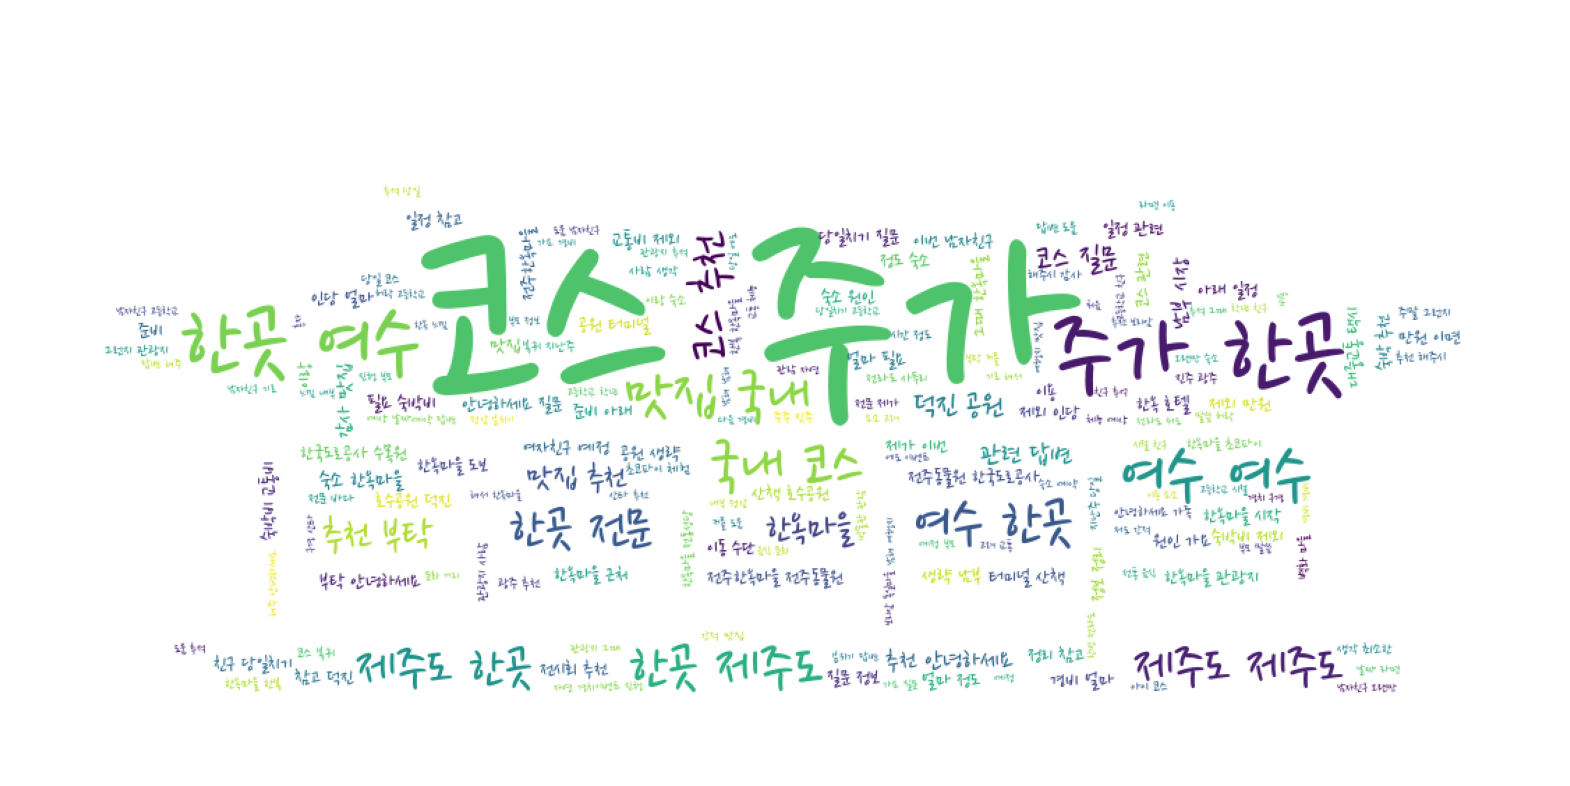

In [44]:
from PIL import Image
mask = np.array(Image.open('data/korea-house-black-fill.png'))
불용어 = set(['경주여행','전주여행'])
wordcloud = WordCloud(
        font_path=font_path,
        background_color='white',
        colormap=color_map,
        max_words=300,
        max_font_size=100,
        mask=mask,
        stopwords=불용어,
        scale=2, # 이미지 크기의 비율(값이 클수록 이미지 저장시 선명도가 높아짐)
        random_state=4,
).generate(jeongju)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')